# Data Preprocessing pt. 1
This script augments VR sensory datasets by injecting small Gaussian noise into orientation and raw sensor data to artificially expand the dataset and improve model generalization. It ensures frame numbers and timestamps are properly updated for the augmented data and uses a nearest neighbor search to generate corresponding tile labels when tile data exists. The processed orientation, raw, and tile files are saved separately in the output folder for later use in training VR viewport prediction models. Configurable parameters include the augmentation factor and noise standard deviation.


*   Input - dataset (orientation, raw and tile data - 500 files each)
*   Output - augmented data (orientation, raw data - 500 files each with doubled amount of rows)





In [ ]:
# STEP 1 preprocessing pt. 1

# STEP 1: Importing required libraries
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# STEP 2: Setting folder paths
orientation_folder = "/content/cleaned_data/sensory/orientation"
raw_folder = "/content/cleaned_data/sensory/raw"
tile_folder = "/content/cleaned_data/sensory/tile"
output_folder = "/content/output_augmented"
os.makedirs(output_folder, exist_ok=True)

# STEP 3: Configuration
augmentation_factor = 2
noise_std = 0.005

# STEP 4: Starting processing
for file_name in tqdm(os.listdir(orientation_folder)):
    if not file_name.endswith(".csv"):
        continue

    orientation_path = os.path.join(orientation_folder, file_name)
    raw_path = os.path.join(raw_folder, file_name.replace("orientation", "raw"))
    tile_path = os.path.join(tile_folder, file_name.replace("orientation", "tiles"))

    try:
        # Orientation
        orientation_df = pd.read_csv(orientation_path)
        last_no_frame = orientation_df.iloc[-1, 0]
        ori_augmented = [orientation_df]

        for i in range(augmentation_factor - 1):
            noisy_df = orientation_df.copy()
            for col in noisy_df.select_dtypes(include=[np.number]).columns:
                noisy_df[col] += np.random.normal(0, noise_std, size=len(noisy_df))
            start_frame = last_no_frame + 1 + i * len(noisy_df)
            noisy_df.iloc[:, 0] = range(start_frame, start_frame + len(noisy_df))
            ori_augmented.append(noisy_df)

        ori_final = pd.concat(ori_augmented, ignore_index=True)

        # Raw
        raw_df = pd.read_csv(raw_path)
        last_ts = raw_df["timestamp"].iloc[-1]
        interval = raw_df["timestamp"].diff().mode().iloc[0] if not raw_df["timestamp"].diff().mode().empty else 1
        raw_augmented = [raw_df]

        for i in range(augmentation_factor - 1):
            noisy_raw = raw_df.copy()
            for col in noisy_raw.select_dtypes(include=[np.number]).columns:
                if col != "timestamp":
                    noisy_raw[col] += np.random.normal(0, noise_std, size=len(noisy_raw))
            start_ts = last_ts + interval + i * len(noisy_raw) * interval
            noisy_raw["timestamp"] = np.arange(start_ts, start_ts + len(noisy_raw) * interval, interval)
            raw_augmented.append(noisy_raw)

        raw_final = pd.concat(raw_augmented, ignore_index=True)

        # Tile
        tile_exists = os.path.exists(tile_path)
        if tile_exists:
            tile_df = pd.read_csv(tile_path, header=None, engine="python")
            ori_numeric = orientation_df.select_dtypes(include=[np.number])
            ori_aug_numeric = ori_final.select_dtypes(include=[np.number])
            knn = NearestNeighbors(n_neighbors=1)
            knn.fit(ori_numeric)
            _, indices = knn.kneighbors(ori_aug_numeric)
            tile_aug = tile_df.iloc[indices.flatten()].reset_index(drop=True)

        # Save outputs
        base = file_name.replace(".csv", "")
        ori_final.to_csv(os.path.join(output_folder, f"{base}_orientation_aug.csv"), index=False)
        raw_final.to_csv(os.path.join(output_folder, f"{base}_raw_aug.csv"), index=False)
        if tile_exists:
            tile_aug.to_csv(os.path.join(output_folder, f"{base}_tiles_aug.csv"),
                            index=False, header=False)

    except Exception as e:
        print(f" Error in {file_name}: {e}")


100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


In [ ]:
# STEP 1 preprocessing pt. 2
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# === CONFIG ===
orientation_folder = "/content/augmented_data/content/output_augmented/orientation_files"
output_tile_folder = "/content/output_aug_tiles"
os.makedirs(output_tile_folder, exist_ok=True)

# === Tile Grid Layout (12 x 9 = 108 tiles)
tile_cols = 12
tile_rows = 9
total_tiles = tile_cols * tile_rows

def yaw_pitch_to_tile(yaw, pitch):
    col = int((yaw + 180) / 360 * tile_cols)
    row = int((pitch + 90) / 180 * tile_rows)
    col = min(max(col, 0), tile_cols - 1)
    row = min(max(row, 0), tile_rows - 1)
    return row * tile_cols + col, row, col

def get_tile_neighborhood(row, col, count=32):
    neighborhood = []
    radius = 1
    while len(neighborhood) < count:
        for dr in range(-radius, radius + 1):
            for dc in range(-radius, radius + 1):
                rr, cc = row + dr, col + dc
                if 0 <= rr < tile_rows and 0 <= cc < tile_cols:
                    tile_id = rr * tile_cols + cc
                    if tile_id not in neighborhood:
                        neighborhood.append(tile_id)
                        if len(neighborhood) >= count:
                            return sorted(neighborhood)
        radius += 1
    return sorted(neighborhood)

# === Process Each File ===
for file in tqdm(sorted(os.listdir(orientation_folder))):
    if not file.endswith(".csv"):
        continue

    try:
        file_path = os.path.join(orientation_folder, file)
        ori_df = pd.read_csv(file_path)

        # Normalize column headers
        ori_df.columns = [col.strip().lower().replace(".", "").replace(" ", "_") for col in ori_df.columns]

        # Find yaw/pitch column names
        yaw_col = next((c for c in ["raw_yaw", "cal_yaw", "yaw"] if c in ori_df.columns), None)
        pitch_col = next((c for c in ["raw_pitch", "cal_pitch", "pitch"] if c in ori_df.columns), None)
        if not yaw_col or not pitch_col:
            print(f"Skipped {file}: no yaw/pitch found.")
            continue

        tile_rows_data = []
        yaw_shift, pitch_shift = 0, 0

        for idx, row in ori_df.iterrows():
            frame_number = int(idx + 1)

            if idx % 10 == 0:
                yaw_shift = np.random.uniform(-10, 10)
                pitch_shift = np.random.uniform(-5, 5)

            yaw = float(row[yaw_col]) + yaw_shift
            pitch = float(row[pitch_col]) + pitch_shift

            center_tile, r, c = yaw_pitch_to_tile(yaw, pitch)
            tile_count = np.random.randint(32, 36)
            tiles = get_tile_neighborhood(r, c, count=tile_count)

            tile_rows_data.append([frame_number] + tiles)

        max_len = max(len(row) for row in tile_rows_data)
        columns = ["no. frames"] + [f"tile{i+1}" for i in range(max_len - 1)]
        tile_df = pd.DataFrame(tile_rows_data, columns=columns).fillna("")

        base_name = file.replace(".csv", "").replace("_orientation", "")
        output_path = os.path.join(output_tile_folder, f"{base_name}_tiles_generated.csv")
        tile_df.to_csv(output_path, index=False)

    except Exception as e:
        print(f" Error in {file}: {e}")


100%|██████████| 500/500 [03:08<00:00,  2.65it/s]


# Data Preprocessing pt. 2
This script generates new tile mapping data based on augmented orientation files. It estimates a viewer's viewport by converting yaw and pitch angles into tile IDs on a 12×9 grid layout. Additionally, it selects a small neighborhood of adjacent tiles to simulate a realistic viewport spread. Yaw and pitch values are slightly shifted every few frames to add natural head movement variation. The generated tile data is saved separately and aligned frame-by-frame for use in VR viewport prediction model training.



*   Input – Augmented orientation data (500 files)
*   Output – Generated tile data (500 files, one tile mapping file per orientation file)




100%|██████████| 500/500 [00:48<00:00, 10.33it/s]


📊 Epoch 1: Loss = 0.0947 | Precision = 0.9389 | Recall = 0.9369 | F1 = 0.9374 | IoU = 0.8908
📊 Epoch 2: Loss = 0.0838 | Precision = 0.9386 | Recall = 0.9393 | F1 = 0.9385 | IoU = 0.8928
📊 Epoch 3: Loss = 0.0820 | Precision = 0.9399 | Recall = 0.9387 | F1 = 0.9388 | IoU = 0.8933
📊 Epoch 4: Loss = 0.0810 | Precision = 0.9405 | Recall = 0.9392 | F1 = 0.9394 | IoU = 0.8942
📊 Epoch 5: Loss = 0.0802 | Precision = 0.9400 | Recall = 0.9399 | F1 = 0.9395 | IoU = 0.8943


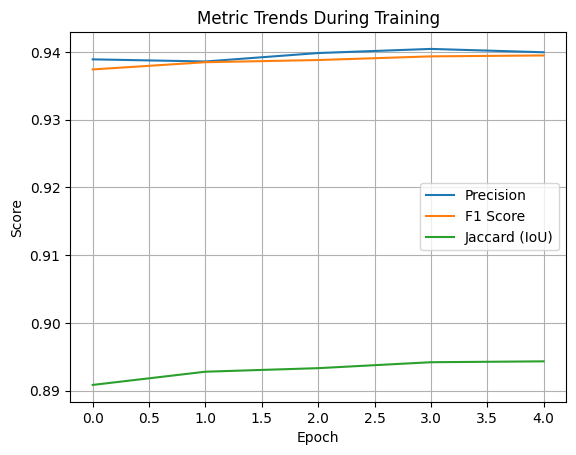


 Sample #119689
 True Tiles:     [15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 31, 32, 33, 39, 40, 41, 42, 43, 44, 52, 53, 54, 55, 56, 64, 65, 66, 67, 68, 76, 77, 78, 79, 80]
 Predicted Tiles: [15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 31, 32, 40, 41, 42, 43, 44, 52, 53, 54, 55, 56, 64, 65, 66, 67, 68, 76, 77, 78, 79, 80]
  Correct: [15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 31, 32, 40, 41, 42, 43, 44, 52, 53, 54, 55, 56, 64, 65, 66, 67, 68, 76, 77, 78, 79, 80]
 Missed : [33, 39]
  Extra  : []

 Sample #99367
 True Tiles:     [17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 54, 55, 56, 57, 58, 66, 67, 68, 69, 70, 78, 79, 80, 81, 82]
 Predicted Tiles: [17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 42, 43, 44, 45, 46, 54, 55, 56, 57, 58, 66, 67, 68, 69, 70, 78, 79, 80, 81, 82]
  Correct: [17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 42, 43, 44, 45, 46, 54, 55, 56, 57, 58, 66, 67, 68, 69, 70, 78, 79, 80, 81, 82]
 Missed : [35]
  Extra  : []

 S

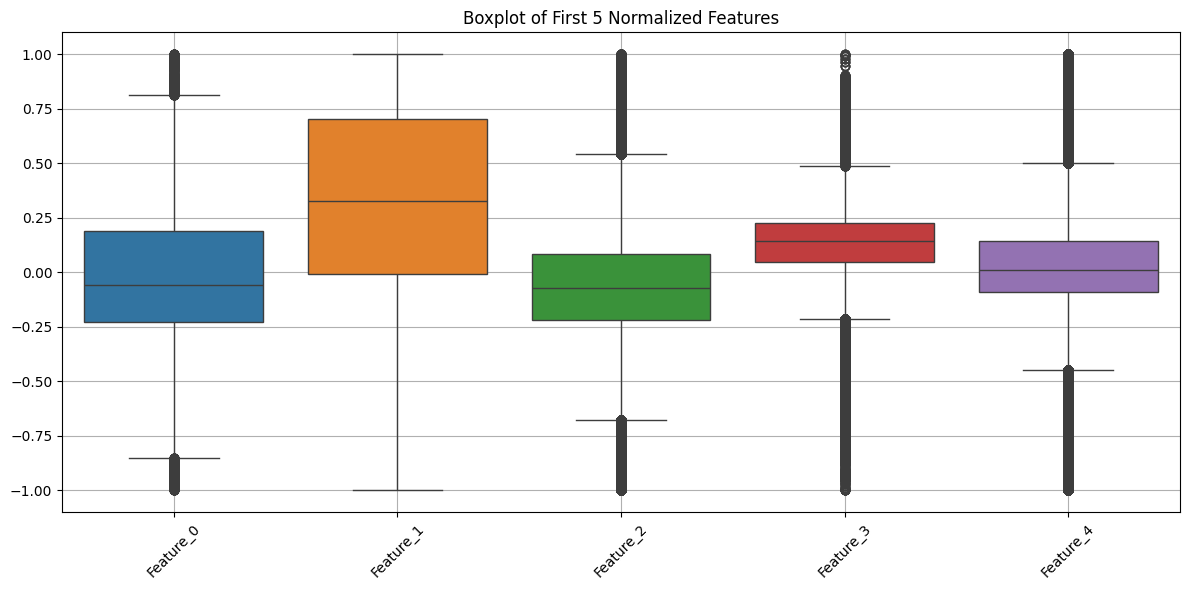

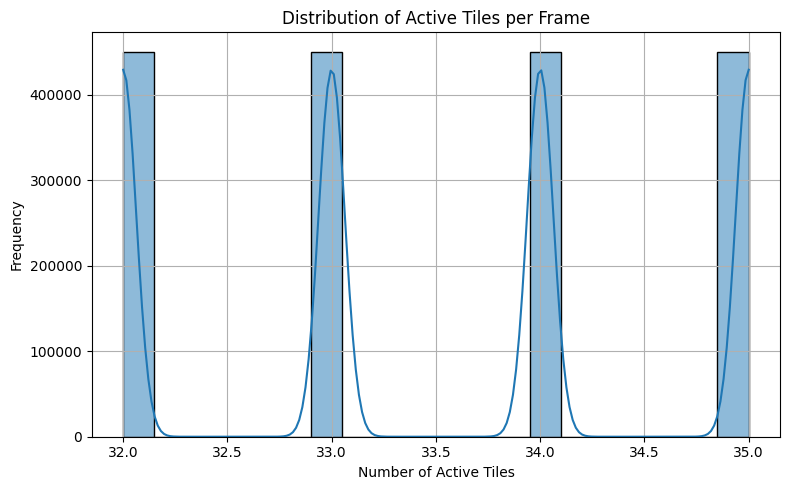

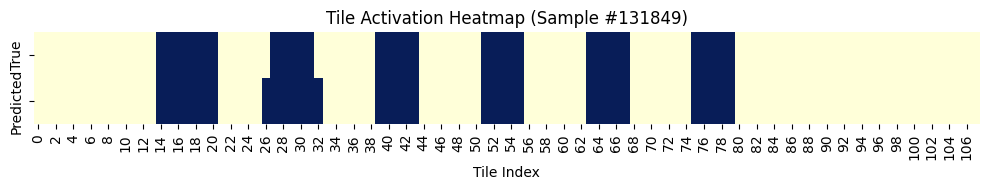

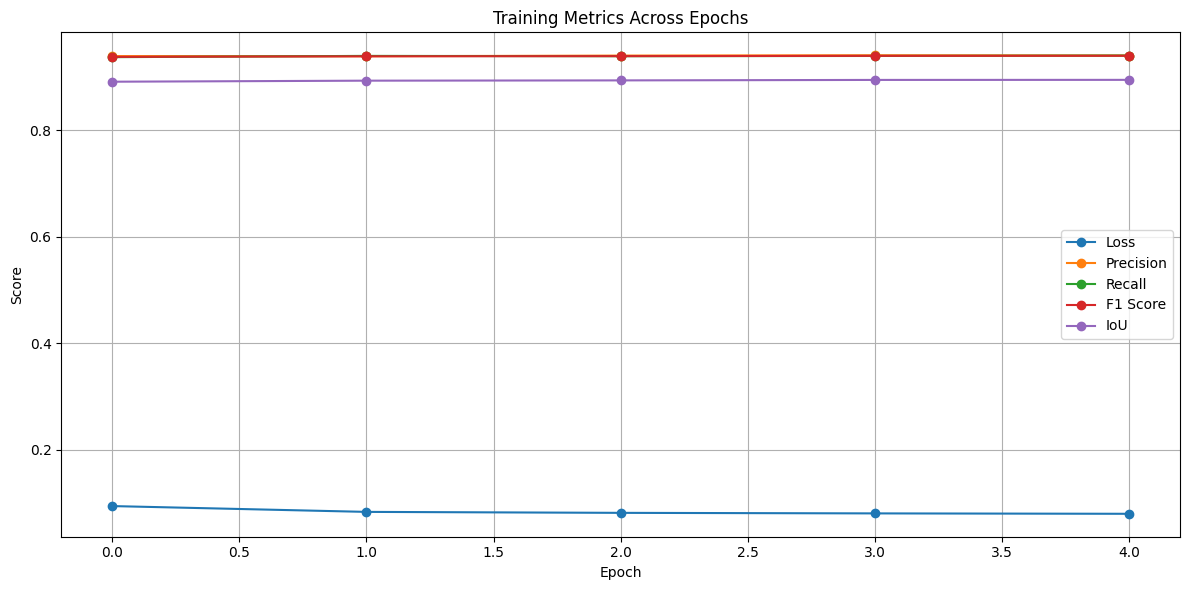

In [ ]:
# STEP 2 algorithm
# Installing necessary libraries
!pip install torch scikit-learn pandas tqdm matplotlib


import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Setting Folder paths
ORIENTATION_FOLDER = "/content/output_augmented/orientation_files"
RAW_FOLDER = "/content/output_augmented/raw_files"
TILE_FOLDER = "/content/output_augmented_tiles"
SEQ_LEN = 10
BATCH_SIZE = 32
EPOCHS = 5


orientation_files = sorted(os.listdir(ORIENTATION_FOLDER))
raw_files = sorted(os.listdir(RAW_FOLDER))
tile_files = sorted(os.listdir(TILE_FOLDER))

all_features, all_labels = [], []

for o_file, r_file, t_file in tqdm(zip(orientation_files, raw_files, tile_files), total=len(orientation_files)):
    try:
        o_df = pd.read_csv(os.path.join(ORIENTATION_FOLDER, o_file))
        r_df = pd.read_csv(os.path.join(RAW_FOLDER, r_file))
        t_df = pd.read_csv(os.path.join(TILE_FOLDER, t_file))

        merged = pd.concat([o_df.reset_index(drop=True), r_df.reset_index(drop=True)], axis=1)
        merged = merged.loc[:, ~merged.columns.duplicated()]
        merged = merged.iloc[:t_df.shape[0]]

        features = merged.drop(columns=["no. frames"], errors="ignore")
        all_features.append(features)
        all_labels.append(t_df.drop(columns=["no. frames"], errors="ignore"))
    except Exception as e:
        print(f" Error in {o_file}, {r_file}, {t_file}: {e}")
        continue

X_all = pd.concat(all_features, ignore_index=True)
y_all_df = pd.concat(all_labels, ignore_index=True)


scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_all)

tile_labels = y_all_df.apply(lambda row: list(row.dropna().astype(int)), axis=1)
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(tile_labels)

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_encoded, SEQ_LEN)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)


class TileDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

dataset = TileDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


class ViewportLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return torch.sigmoid(self.fc(hn[-1]))

model = ViewportLSTM(input_size=X_tensor.shape[2], hidden_size=64, output_size=y_tensor.shape[1])
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


metrics = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = (model(xb) > 0.5).float()
            all_preds.append(preds.numpy())
            all_labels.append(yb.numpy())

    y_pred_np = np.vstack(all_preds)
    y_true_np = np.vstack(all_labels)

    precision = precision_score(y_true_np, y_pred_np, average="samples", zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average="samples", zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average="samples", zero_division=0)

    def jaccard_index(y_true, y_pred):
        intersect = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        return np.mean(intersect / np.clip(union, a_min=1, a_max=None))

    iou = jaccard_index(y_true_np, y_pred_np)
    metrics.append((total_loss / len(train_loader), precision, recall, f1, iou))

    print(f"📊 Epoch {epoch+1}: Loss = {metrics[-1][0]:.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f} | IoU = {iou:.4f}")


losses, precisions, recalls, f1s, ious = zip(*metrics)
plt.plot(precisions, label="Precision")
plt.plot(f1s, label="F1 Score")
plt.plot(ious, label="Jaccard (IoU)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metric Trends During Training")
plt.legend()
plt.grid(True)
plt.show()


np.random.seed(42)
sample_indices = np.random.choice(len(y_true_np), 3, replace=False)

for i in sample_indices:
    true_tiles = np.where(y_true_np[i] == 1)[0].tolist()
    pred_tiles = np.where(y_pred_np[i] == 1)[0].tolist()

    print(f"\n Sample #{i}")
    print(f" True Tiles:     {true_tiles}")
    print(f" Predicted Tiles: {pred_tiles}")

    correct = set(true_tiles) & set(pred_tiles)
    missed = set(true_tiles) - set(pred_tiles)
    extras = set(pred_tiles) - set(true_tiles)

    print(f"  Correct: {sorted(correct)}")
    print(f" Missed : {sorted(missed)}")
    print(f"  Extra  : {sorted(extras)}")

import seaborn as sns

# 1. Boxplot of First 5 Normalized Features
feature_df = pd.DataFrame(X_scaled[:, :5], columns=[f"Feature_{i}" for i in range(5)])
plt.figure(figsize=(12, 6))
sns.boxplot(data=feature_df)
plt.title("Boxplot of First 5 Normalized Features")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribution of Active Tiles per Frame
active_tile_counts = y_all_df.notna().sum(axis=1)
plt.figure(figsize=(8, 5))
sns.histplot(active_tile_counts, bins=20, kde=True)
plt.title("Distribution of Active Tiles per Frame")
plt.xlabel("Number of Active Tiles")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Heatmap of Actual vs Predicted for One Random Sample
sample_idx = np.random.choice(len(y_true_np))
sample_true = y_true_np[sample_idx]
sample_pred = y_pred_np[sample_idx]

plt.figure(figsize=(10, 2))
sns.heatmap([sample_true, sample_pred], cmap="YlGnBu", cbar=False, yticklabels=["True", "Predicted"])
plt.title(f"Tile Activation Heatmap (Sample #{sample_idx})")
plt.xlabel("Tile Index")
plt.tight_layout()
plt.show()

# 4. Line Plot of Training Metrics
metrics_df = pd.DataFrame(metrics, columns=["Loss", "Precision", "Recall", "F1 Score", "IoU"])
metrics_df.plot(figsize=(12, 6), marker='o')
plt.title("Training Metrics Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


# Algorithm Training - VR Viewport Prediction
This script builds and trains an LSTM-based deep learning model to predict VR viewport tiles based on orientation and raw sensor data. It prepares sequential data samples, encodes multi-label tile targets, and evaluates the model's performance across multiple epochs using key metrics like Precision, Recall, F1 Score, and IoU (Intersection over Union). Various visualizations are also generated to analyze feature distributions and model performance trends.



*  Input – Preprocessed and augmented orientation, raw, and tile data (500 files each)
*  Output – Trained model metrics, detailed sample predictions, and multiple plots to interpret results



In [ ]:
import zipfile
import os

zip_path = "/content/output_aug_tiles.zip"
extract_to = "/content/output_augmented_tiles"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped:", zip_path)


zip_path = "/content/output_augmented.zip"
extract_to = "/content/output_augmented"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped:", zip_path)



✅ Unzipped: /content/output_aug_tiles.zip
✅ Unzipped: /content/output_augmented.zip


In [ ]:
# STEP 1: Install Necessary Libraries
!pip install torch scikit-learn pandas tqdm matplotlib seaborn

# STEP 2: Import Libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# STEP 3: Set Folder Paths and Config
ORIENTATION_FOLDER = "/content/output_augmented/orientation_files"
RAW_FOLDER = "/content/output_augmented/raw_files"
TILE_FOLDER = "/content/output_augmented_tiles"
SEQ_LEN = 10
BATCH_SIZE = 32
EPOCHS = 5

# STEP 4: Data Loading and Preprocessing
orientation_files = sorted(os.listdir(ORIENTATION_FOLDER))
raw_files = sorted(os.listdir(RAW_FOLDER))
tile_files = sorted(os.listdir(TILE_FOLDER))

all_features, all_labels = [], []

for o_file, r_file, t_file in tqdm(zip(orientation_files, raw_files, tile_files), total=len(orientation_files)):
    try:
        o_df = pd.read_csv(os.path.join(ORIENTATION_FOLDER, o_file))
        r_df = pd.read_csv(os.path.join(RAW_FOLDER, r_file))
        t_df = pd.read_csv(os.path.join(TILE_FOLDER, t_file))

        merged = pd.concat([o_df.reset_index(drop=True), r_df.reset_index(drop=True)], axis=1)
        merged = merged.loc[:, ~merged.columns.duplicated()]
        merged = merged.iloc[:t_df.shape[0]]

        features = merged.drop(columns=["no. frames"], errors="ignore")
        all_features.append(features)
        all_labels.append(t_df.drop(columns=["no. frames"], errors="ignore"))
    except Exception as e:
        print(f"⚠️ Error in {o_file}, {r_file}, {t_file}: {e}")

X_all = pd.concat(all_features, ignore_index=True)
y_all_df = pd.concat(all_labels, ignore_index=True)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_all)

tile_labels = y_all_df.apply(lambda row: list(row.dropna().astype(int)), axis=1)
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(tile_labels)

# STEP 5: Create Sequences for LSTM

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_encoded, SEQ_LEN)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# STEP 6: PyTorch Dataset and Dataloader
class TileDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TileDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# STEP 7: Define LSTM Model
class ViewportLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return torch.sigmoid(self.fc(hn[-1]))

model = ViewportLSTM(input_size=X_tensor.shape[2], hidden_size=64, output_size=y_tensor.shape[1])
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# STEP 8: Train LSTM Model
metrics = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = (model(xb) > 0.5).float()
            all_preds.append(preds.numpy())
            all_labels.append(yb.numpy())

    y_pred_np = np.vstack(all_preds)
    y_true_np = np.vstack(all_labels)

    precision = precision_score(y_true_np, y_pred_np, average="samples", zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average="samples", zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average="samples", zero_division=0)

    def jaccard_index(y_true, y_pred):
        intersect = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        return np.mean(intersect / np.clip(union, a_min=1, a_max=None))

    iou = jaccard_index(y_true_np, y_pred_np)
    metrics.append((total_loss / len(train_loader), precision, recall, f1, iou))

    print(f"📊 Epoch {epoch+1}: Loss = {metrics[-1][0]:.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f} | IoU = {iou:.4f}")
# Save X_seq, y_seq, and metrics
np.save("/content/X_seq.npy", X_seq)
np.save("/content/y_seq.npy", y_seq)
np.save("/content/metrics.npy", np.array(metrics))


100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


📊 Epoch 1: Loss = 0.0953 | Precision = 0.9377 | Recall = 0.9364 | F1 = 0.9366 | IoU = 0.8895
📊 Epoch 2: Loss = 0.0838 | Precision = 0.9405 | Recall = 0.9388 | F1 = 0.9392 | IoU = 0.8939
📊 Epoch 3: Loss = 0.0819 | Precision = 0.9397 | Recall = 0.9396 | F1 = 0.9392 | IoU = 0.8939
📊 Epoch 4: Loss = 0.0809 | Precision = 0.9402 | Recall = 0.9402 | F1 = 0.9398 | IoU = 0.8949
📊 Epoch 5: Loss = 0.0803 | Precision = 0.9416 | Recall = 0.9382 | F1 = 0.9395 | IoU = 0.8944


# Model Comparison - Traditional ML vs LSTM
This script compares the performance of simple traditional machine learning models (Logistic Regression and Linear SVC) against the trained LSTM model. It evaluates how well fast models perform on a small sample of the dataset compared to the deep learning approach in predicting VR viewport tiles.

* Input – Processed sequence dataset (X_seq, y_seq) and LSTM training metrics
* Output – Clear quantitative and visual comparison showing the strengths of sequence modeling (LSTM) over fast traditional classifiers






Training Logistic Regression...

Training Linear SVC...


🚀 FAST Model Comparison Table (20% Sample):
                 Model  Precision    Recall  F1 Score       IoU
0  Logistic Regression   0.876419  0.891353  0.878787  0.789424
1           Linear SVC   0.871961  0.887941  0.874756  0.783379
2                 LSTM   0.941650  0.938179  0.939460  0.894372


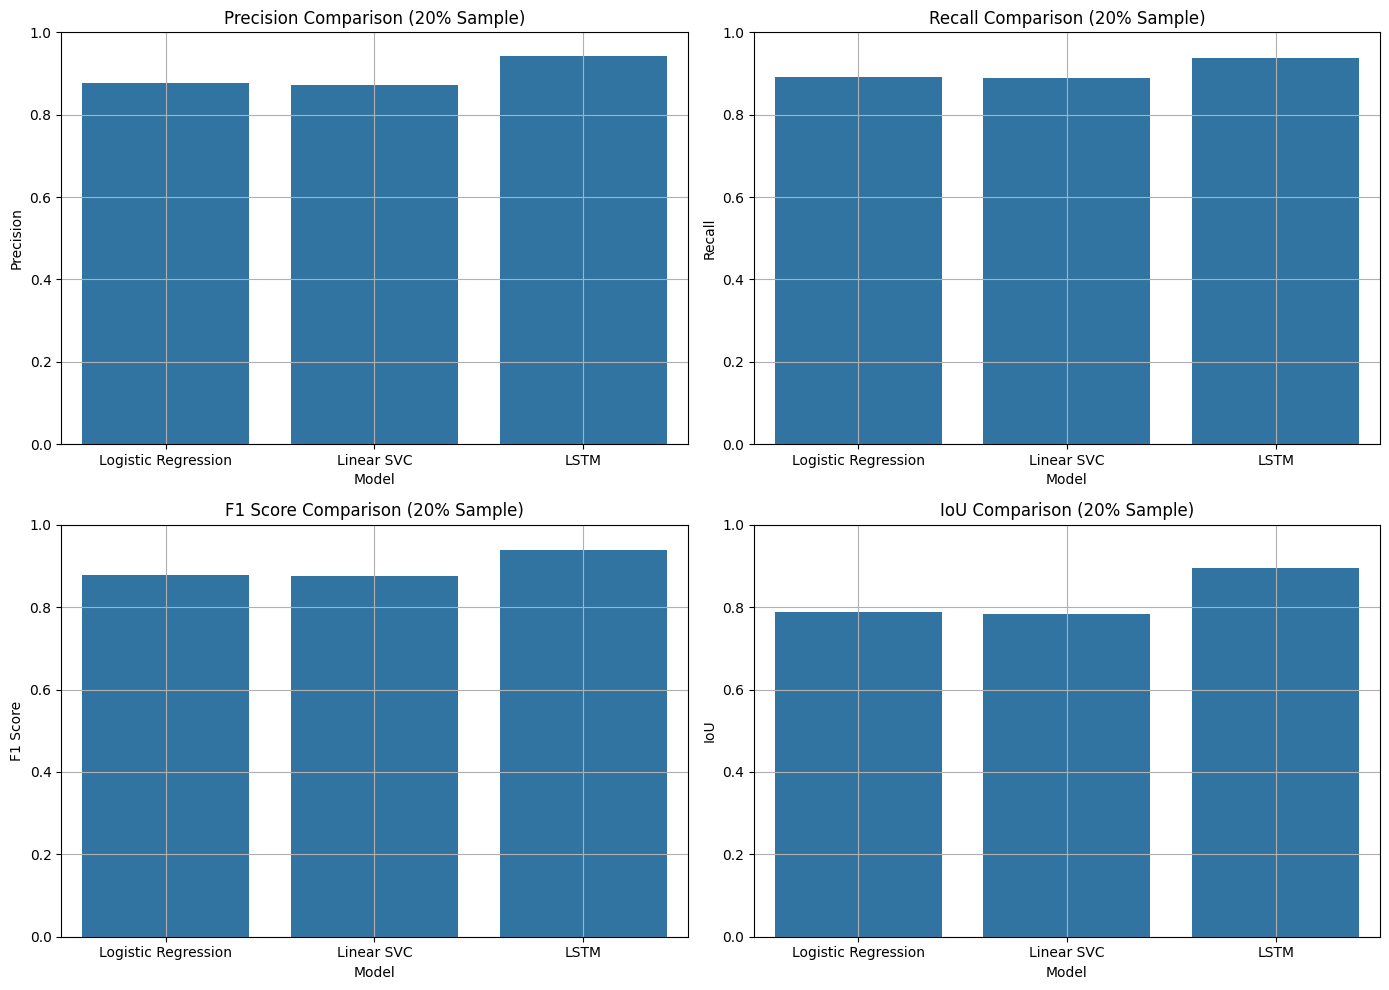

In [ ]:
# STEP 3 : comparison of the results
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load saved data
X_seq = np.load("/content/X_seq.npy")
y_seq = np.load("/content/y_seq.npy")
metrics = np.load("/content/metrics.npy", allow_pickle=True).tolist()

# Flatten LSTM sequences
X_flat = X_seq.reshape(X_seq.shape[0], -1)

sample_size = int(0.02 * len(X_flat))
np.random.seed(42)
indices = np.random.choice(len(X_flat), sample_size, replace=False)
X_flat_sampled = X_flat[indices]
y_seq_sampled = y_seq[indices]

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X_flat_sampled, y_seq_sampled, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": MultiOutputClassifier(
        LogisticRegression(max_iter=300, solver='saga', penalty='l2', random_state=42)
    ),
    "Linear SVC": MultiOutputClassifier(
        LinearSVC(max_iter=3000, random_state=42)
    )
}

#  Train and Evaluate Models
results = []

for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    precision = precision_score(y_val, y_pred, average="samples", zero_division=0)
    recall = recall_score(y_val, y_pred, average="samples", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="samples", zero_division=0)
    iou = np.mean([
        np.sum(np.logical_and(y_val[i], y_pred[i])) / np.clip(np.sum(np.logical_or(y_val[i], y_pred[i])), a_min=1, a_max=None)
        for i in range(len(y_val))
    ])

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "IoU": iou
    })

# Adding LSTM Results
lstm_last = metrics[-1]
results.append({
    "Model": "LSTM",
    "Precision": lstm_last[1],
    "Recall": lstm_last[2],
    "F1 Score": lstm_last[3],
    "IoU": lstm_last[4]
})

#  Results Table
results_df = pd.DataFrame(results)

print("\n\n🚀 FAST Model Comparison Table (20% Sample):")
print(results_df)

#  Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, metric in enumerate(["Precision", "Recall", "F1 Score", "IoU"]):
    ax = axes[i//2, i%2]
    sns.barplot(x="Model", y=metric, data=results_df, ax=ax)
    ax.set_ylim(0, 1)
    ax.set_title(f"{metric} Comparison (20% Sample)")
    ax.grid(True)

plt.tight_layout()
plt.show()


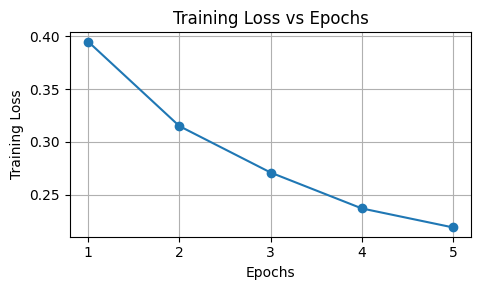

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
training_loss = [0.395, 0.315, 0.271, 0.237, 0.219]


plt.figure(figsize=(5,3))
plt.plot(epochs, training_loss, marker='o', linestyle='-', linewidth=1.5)
plt.title('Training Loss vs Epochs', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Training Loss', fontsize=10)
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.savefig('training_loss_vs_epochs_small.png', dpi=300)
plt.show()


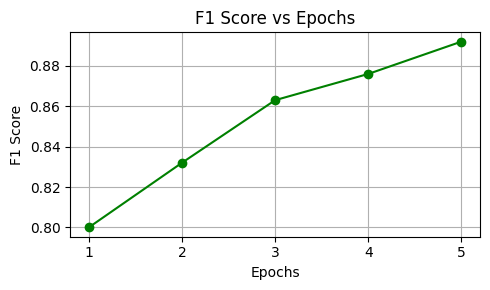

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
f1_scores = [0.800, 0.832, 0.863, 0.876, 0.892]


plt.figure(figsize=(5,3))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', linewidth=1.5, color='green')
plt.title('F1 Score vs Epochs', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('F1 Score', fontsize=10)
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.savefig('f1_score_vs_epochs_small.png', dpi=300)  # Save with high resolution
plt.show()
